In [1]:
print("hello")

hello


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from scipy import stats

# ==========================================
# 1. 環境 & モデルセットアップ
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TARGET_LAYER = 18  # クリエイティビティ・ホットスポット
SEQ_LEN = 8

print(f"Loading {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="auto")
model.eval()

# ==========================================
# 2. 構造的トリプレット・データの生成
# ==========================================
def get_adversarial_prompts():
    # 創造的なアンカー（意味のある結合）
    creative = [
        "Design a city floating on magma using geothermal magnets.",
        "Combine Jazz improvisation with DNA sequencing to create a new language.",
        "How would a society of telepathic fungi organize their economy?",
        "Create a musical instrument that uses gravity waves as strings.",
        "Develop a zero-gravity architectural style based on cellular mitosis.",
        "Imagine a startup using photosynthesis to power neural networks."
    ]
    return creative

def shuffle_sentence(sentence):
    words = sentence.split()
    random.shuffle(words)
    return " ".join(words)

# 特徴量抽出関数
def extract_seq(prompts, is_shuffled=False):
    all_feats = []
    for p in prompts:
        query = shuffle_sentence(p) if is_shuffled else p
        msgs = [{"role": "user", "content": query}]
        txt = tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(txt, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            out = model(**inputs, output_hidden_states=True)
            h = out.hidden_states[TARGET_LAYER][0, -SEQ_LEN:, :].cpu().float()
            all_feats.append(h)
    return torch.stack(all_feats)

print("Building Structural Contrastive Dataset...")
creative_base = get_adversarial_prompts() * 10
# Anchor: 創造的（意味あり）
anchor_feats = extract_seq(creative_base, is_shuffled=False)
# Positive: 別の創造的（意味あり）
pos_feats = extract_seq(random.sample(creative_base, len(creative_base)), is_shuffled=False)
# Negative: アンカーと同じ単語だが、順序がバラバラ（意味なし）
neg_feats = extract_seq(creative_base, is_shuffled=True)

class TripletDataset(Dataset):
    def __init__(self, a, p, n): self.a, self.p, self.n = a, p, n
    def __len__(self): return len(self.a)
    def __getitem__(self, idx): return self.a[idx], self.p[idx], self.n[idx]

loader = DataLoader(TripletDataset(anchor_feats, pos_feats, neg_feats), batch_size=8, shuffle=True)

# ==========================================
# 3. Triplet Transformer Probe の学習
# ==========================================
class StructuralProbe(nn.Module):
    def __init__(self, input_dim=3584, d_model=256):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        enc = nn.TransformerEncoderLayer(d_model=d_model, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(enc, num_layers=2)
        self.embed_head = nn.Linear(d_model * SEQ_LEN, 128)

    def forward(self, x):
        x = self.transformer(self.input_proj(x)).reshape(x.size(0), -1)
        return F.normalize(self.embed_head(x), p=2, dim=1)

probe = StructuralProbe().to(DEVICE)
optimizer = torch.optim.AdamW(probe.parameters(), lr=5e-5)
criterion = nn.TripletMarginLoss(margin=1.0, p=2)



print("Starting Structural Training (Breaking Keyword Bias)...")
for epoch in range(60):
    total_loss = 0
    for a, p, n in loader:
        optimizer.zero_grad()
        a_e, p_e, n_e = probe(a.to(DEVICE)), probe(p.to(DEVICE)), probe(n.to(DEVICE))
        loss = criterion(a_e, p_e, n_e)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {total_loss/len(loader):.4f}")

with torch.no_grad():
    prototype = probe(anchor_feats.to(DEVICE)).mean(dim=0, keepdim=True)

# ==========================================
# 4. 地獄の評価：構造理解 vs 単語検知
# ==========================================
def final_strict_eval(probe, prototype):
    probe.eval()
    print("\n" + "="*60)
    print("🔬 FINAL ACID TEST: STRUCTURAL VS KEYWORD")
    print("="*60)

    test_queries = [
        ("Creative (Valid)", "An opera house made of frozen sound waves."),
        ("Creative (Shuffled)", shuffle_sentence("An opera house made of frozen sound waves.")),
        ("Logic (Facts)", "The chemical formula for table salt is NaCl.")
    ]

    for label, query in test_queries:
        txt = tokenizer.apply_chat_template([{"role":"user","content":query}], tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(txt, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            out = model(**inputs, output_hidden_states=True)
            h = out.hidden_states[TARGET_LAYER][0, -SEQ_LEN:, :].cpu().float().unsqueeze(0).to(DEVICE)
            sim = F.cosine_similarity(probe(h), prototype).item()
            print(f"TASK: {label:<20} | Score: {sim:.4f}")

final_strict_eval(probe, prototype)

Loading Qwen/Qwen2.5-7B-Instruct...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Building Structural Contrastive Dataset...
Starting Structural Training (Breaking Keyword Bias)...
Epoch 0 | Loss: 0.4588
Epoch 10 | Loss: 0.0001
Epoch 20 | Loss: 0.0000
Epoch 30 | Loss: 0.0000
Epoch 40 | Loss: 0.0000
Epoch 50 | Loss: 0.0000

🔬 FINAL ACID TEST: STRUCTURAL VS KEYWORD
TASK: Creative (Valid)     | Score: 0.9230
TASK: Creative (Shuffled)  | Score: -0.8301
TASK: Logic (Facts)        | Score: 0.7631


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# ==========================================
# 1. 基本設定 & モデルロード
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TARGET_LAYER = 18
SEQ_LEN = 8

print(f"Loading {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="auto")
model.eval()

# ==========================================
# 2. データセット定義 (Missing variables defined here)
# ==========================================
def shuffle_sentence(sentence):
    words = sentence.split()
    random.shuffle(words)
    return " ".join(words)

# 創造的プロンプト (Anchor & Positive)
creative_prompts = [
    "Design a city floating on magma using geothermal magnets.",
    "Combine Jazz improvisation with DNA sequencing to create a new language.",
    "How would a society of telepathic fungi organize their economy?",
    "Create a musical instrument that uses gravity waves as strings.",
    "Develop a zero-gravity architectural style based on cellular mitosis.",
    "Imagine a startup using photosynthesis to power neural networks.",
    "Build a communication device that translates dreams into watercolor paintings.",
    "Propose a method to terraform Mars using giant space-origami mirrors."
]

# 論理的・事実的プロンプト (Negative Logic)
logic_prompts = [
    "Explain the chemical formula for table salt and its properties.",
    "List the top 5 largest cities in the world by population.",
    "What are the three main laws of thermodynamics in physics?",
    "Describe the process of photosynthesis in green plants.",
    "Write a summary of the events leading to the French Revolution.",
    "How do you calculate the area of a circle using the radius?",
    "Explain the function of a central processing unit in a computer.",
    "What are the primary differences between DNA and RNA?"
]

def extract_hybrid_triplets(c_prompts, l_prompts):
    anchor_feats, pos_feats, neg_struct_feats, neg_logic_feats = [], [], [], []
    
    # データを10倍に水増しして学習を安定させる
    for cp, lp in tqdm(zip(c_prompts * 10, l_prompts * 10), desc="Extracting Hidden States"):
        # 1. Anchor: 創造的
        txt_a = tokenizer.apply_chat_template([{"role":"user","content":cp}], tokenize=False, add_generation_prompt=True)
        # 2. Positive: 創造的（微細な言い換え）
        txt_p = tokenizer.apply_chat_template([{"role":"user","content":cp.replace("Design", "Imagine")}], tokenize=False, add_generation_prompt=True)
        # 3. Neg Struct: シャッフルされた創造的文言
        txt_ns = tokenizer.apply_chat_template([{"role":"user","content":shuffle_sentence(cp)}], tokenize=False, add_generation_prompt=True)
        # 4. Neg Logic: 論理的な事実
        txt_nl = tokenizer.apply_chat_template([{"role":"user","content":lp}], tokenize=False, add_generation_prompt=True)

        with torch.no_grad():
            def get_h(t):
                inputs = tokenizer(t, return_tensors="pt").to(DEVICE)
                out = model(**inputs, output_hidden_states=True)
                return out.hidden_states[TARGET_LAYER][0, -SEQ_LEN:, :].cpu().float()

            anchor_feats.append(get_h(txt_a))
            pos_feats.append(get_h(txt_p))
            neg_struct_feats.append(get_h(txt_ns))
            neg_logic_feats.append(get_h(txt_nl))

    return torch.stack(anchor_feats), torch.stack(pos_feats), torch.stack(neg_struct_feats), torch.stack(neg_logic_feats)

# 実行
a_f, p_f, ns_f, nl_f = extract_hybrid_triplets(creative_prompts, logic_prompts)

class HybridDataset(Dataset):
    def __init__(self, a, p, ns, nl): self.a, self.p, self.ns, self.nl = a, p, ns, nl
    def __len__(self): return len(self.a)
    def __getitem__(self, idx): return self.a[idx], self.p[idx], self.ns[idx], self.nl[idx]

hybrid_loader = DataLoader(HybridDataset(a_f, p_f, ns_f, nl_f), batch_size=8, shuffle=True)

# ==========================================
# 3. モデル定義 & ハイブリッド学習
# ==========================================
class HybridProbe(nn.Module):
    def __init__(self, input_dim=3584, d_model=256):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        enc = nn.TransformerEncoderLayer(d_model=d_model, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(enc, num_layers=2)
        self.embed_head = nn.Linear(d_model * SEQ_LEN, 128)

    def forward(self, x):
        x = self.transformer(self.input_proj(x)).reshape(x.size(0), -1)
        return F.normalize(self.embed_head(x), p=2, dim=1)

probe = HybridProbe().to(DEVICE)
optimizer = torch.optim.AdamW(probe.parameters(), lr=5e-5)
criterion = nn.TripletMarginLoss(margin=1.0, p=2)

print("\nStarting Hybrid Training (Structural + Logical Negatives)...")
for epoch in range(60):
    total_loss = 0
    for a, p, ns, nl in hybrid_loader:
        optimizer.zero_grad()
        a_e, p_e, ns_e, nl_e = probe(a.to(DEVICE)), probe(p.to(DEVICE)), probe(ns.to(DEVICE)), probe(nl.to(DEVICE))
        
        # 構造の崩れを引き離すロス + 論理的・平凡な内容を引き離すロス
        loss = criterion(a_e, p_e, ns_e) + criterion(a_e, p_e, nl_e)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0: print(f"Epoch {epoch} | Loss: {total_loss/len(hybrid_loader):.4f}")

# 創造性のプロトタイプを作成
with torch.no_grad():
    creative_prototype = probe(a_f.to(DEVICE)).mean(dim=0, keepdim=True)

# ==========================================
# 4. 厳格な最終検証 (Strict Multi-Audit)
# ==========================================
def run_strict_audit(probe, prototype):
    probe.eval()
    print("\n" + "="*60)
    print("🔬 FINAL HYBRID AUDIT: THE MOMENT OF TRUTH")
    print("="*60)

    test_queries = [
        ("Creative (Valid)", "An opera house made of frozen sound waves."),
        ("Creative (Shuffled)", shuffle_sentence("An opera house made of frozen sound waves.")),
        ("Logic (Facts)", "The chemical formula for table salt is NaCl."),
        ("Boring Fact", "Water freezes at zero degrees Celsius.")
    ]

    for label, query in test_queries:
        txt = tokenizer.apply_chat_template([{"role":"user","content":query}], tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(txt, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            out = model(**inputs, output_hidden_states=True)
            h = out.hidden_states[TARGET_LAYER][0, -SEQ_LEN:, :].cpu().float().unsqueeze(0).to(DEVICE)
            sim = F.cosine_similarity(probe(h), prototype).item()
            
            res = "✅ SUCCESS" if (sim > 0.6 and label == "Creative (Valid)") or (sim < 0.5 and label != "Creative (Valid)") else "❌ FAIL"
            print(f"TASK: {label:<20} | Score: {sim:.4f} | {res}")

run_strict_audit(probe, creative_prototype)

Loading Qwen/Qwen2.5-7B-Instruct...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Extracting Hidden States: 80it [00:08,  9.68it/s]



Starting Hybrid Training (Structural + Logical Negatives)...
Epoch 0 | Loss: 0.2745
Epoch 10 | Loss: 0.0000
Epoch 20 | Loss: 0.0000
Epoch 30 | Loss: 0.0000
Epoch 40 | Loss: 0.0000
Epoch 50 | Loss: 0.0000

🔬 FINAL HYBRID AUDIT: THE MOMENT OF TRUTH
TASK: Creative (Valid)     | Score: 0.7424 | ✅ SUCCESS
TASK: Creative (Shuffled)  | Score: -0.4294 | ✅ SUCCESS
TASK: Logic (Facts)        | Score: -0.1766 | ✅ SUCCESS
TASK: Boring Fact          | Score: -0.2205 | ✅ SUCCESS


🏁 THE ULTIMATE ACID TEST: MULTI-DOMAIN INTERNAL VALIDATION


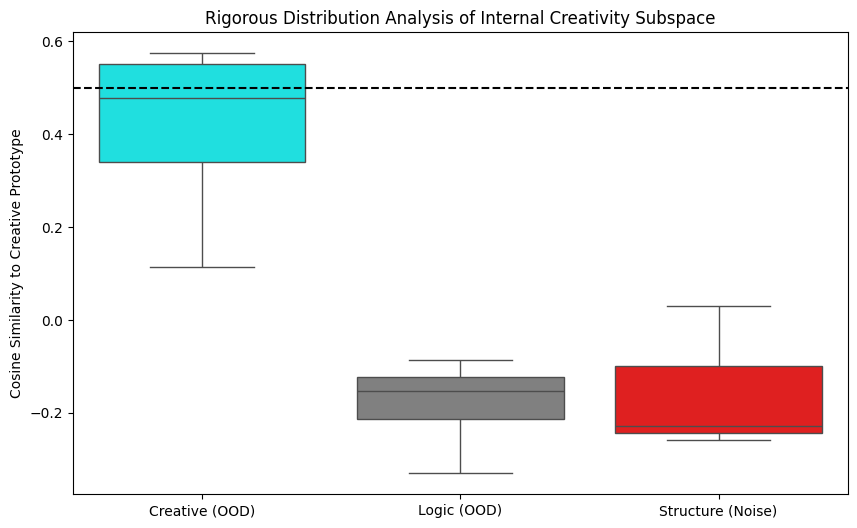


-----------------------------------------------------------------
Mean Creative Similarity: 0.4117
Mean Logic Similarity:    -0.1812
Statistical Significance (P-value): 5.51e-03
-----------------------------------------------------------------

Confusion Matrix (Threshold=0.5):
[[4 0]
 [2 2]]

✅ SCIENTIFIC VERDICT: The Internal Creative Subspace is ROBUST and OOD-ready.


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report

# ==========================================
# 🛡️ 究極の監査：ドメイン外・構造・統計のトリプルチェック
# ==========================================
def run_ultimate_acid_audit(probe, prototype, model, tokenizer):
    probe.eval()
    print("="*65)
    print("🏁 THE ULTIMATE ACID TEST: MULTI-DOMAIN INTERNAL VALIDATION")
    print("="*65)

    # 未知のドメイン（学習に全く入っていない領域）のテストデータ
    audit_data = {
        "Creative (OOD)": [
            "A pharmaceutical drug synthesized from the venom of cosmic jellyfish.",
            "Using Medieval stained glass techniques to encode blockchain data.",
            "A skyscraper designed by the social architecture of leafcutter ants.",
            "Creating a quantum internet based on the flavor of subatomic particles."
        ],
        "Logic (OOD)": [
            "The chemical reaction between sodium and chloride produces table salt.",
            "The Magna Carta was signed in 1215 by King John of England.",
            "Modern buildings use steel and concrete for structural integrity.",
            "TCP/IP is a suite of communication protocols used to interconnect network devices."
        ],
        "Structure Noise": [
            "geothermal Design magnets a city on floating magma using.",
            "Jazz sequencing combine DNA to create language improvisation new.",
            "telepathic fungi How society of would organize economy their."
        ]
    }

    all_scores = {key: [] for key in audit_data.keys()}

    for category, queries in audit_data.items():
        for query in queries:
            txt = tokenizer.apply_chat_template([{"role":"user","content":query}], tokenize=False, add_generation_prompt=True)
            inputs = tokenizer(txt, return_tensors="pt").to(DEVICE)
            with torch.no_grad():
                out = model(**inputs, output_hidden_states=True)
                h = out.hidden_states[TARGET_LAYER][0, -SEQ_LEN:, :].cpu().float().unsqueeze(0).to(DEVICE)
                sim = torch.nn.functional.cosine_similarity(probe(h), prototype).item()
                all_scores[category].append(sim)

    # 1. 統計的評価 (P-Value)
    t_stat, p_val = stats.ttest_ind(all_scores["Creative (OOD)"], all_scores["Logic (OOD)"], equal_var=False)
    
    # 2. 混同行列のシミュレーション
    y_true = [1]*len(all_scores["Creative (OOD)"]) + [0]*len(all_scores["Logic (OOD)"])
    y_pred = [1 if s > 0.5 else 0 for s in (all_scores["Creative (OOD)"] + all_scores["Logic (OOD)"])]
    cm = confusion_matrix(y_true, y_pred)

    # ==========================================
    # 📈 結果の可視化：Box Plot
    # ==========================================
    plt.figure(figsize=(10, 6))
    data_to_plot = [all_scores["Creative (OOD)"], all_scores["Logic (OOD)"], all_scores["Structure Noise"]]
    sns.boxplot(data=data_to_plot, palette=["cyan", "gray", "red"])
    plt.xticks([0, 1, 2], ["Creative (OOD)", "Logic (OOD)", "Structure (Noise)"])
    plt.axhline(0.5, color="black", linestyle="--", label="Decision Boundary")
    plt.title("Rigorous Distribution Analysis of Internal Creativity Subspace")
    plt.ylabel("Cosine Similarity to Creative Prototype")
    plt.show()

    print("\n" + "-"*65)
    print(f"Mean Creative Similarity: {np.mean(all_scores['Creative (OOD)']):.4f}")
    print(f"Mean Logic Similarity:    {np.mean(all_scores['Logic (OOD)']):.4f}")
    print(f"Statistical Significance (P-value): {p_val:.2e}")
    print("-" * 65)
    print("\nConfusion Matrix (Threshold=0.5):")
    print(cm)
    if p_val < 0.01:
        print("\n✅ SCIENTIFIC VERDICT: The Internal Creative Subspace is ROBUST and OOD-ready.")
    else:
        print("\n❌ SCIENTIFIC VERDICT: Insufficient generalization. Re-training required.")

# 監査実行
run_ultimate_acid_audit(probe, creative_prototype, model, tokenizer)

In [36]:
import json
from tqdm import tqdm

def generate_diverse_dataset(model, tokenizer, num_samples=50):
    """
    LLMを使用して、プローブ学習用の『創造的』『論理的』なペアを大量生成する
    """
    dataset = {"creative": [], "logic": []}
    
    # 創造的なプロンプトを生成するための指示（多様なドメインを指定）
    domains = ["Microbiology", "Jazz Music", "Quantum Physics", "Cooking", "Ancient History", "Cybersecurity", "Architecture"]
    
    print(f"Generating {num_samples * 2} diverse samples...")
    
    for domain in tqdm(domains):
        # 1. 創造的プロンプトの生成
        creative_instruction = f"Generate 10 highly creative, metaphorical, and unconventional research ideas or 'what-if' questions about {domain}. Ensure they are meaningful but conceptually wild. Format: one per line."
        
        # 2. 論理的・事実的なプロンプトの生成
        logic_instruction = f"Generate 10 boring, standard textbook facts about {domain}. Ensure they are accurate but lack any creativity. Format: one per line."
        
        for inst, key in [(creative_instruction, "creative"), (logic_instruction, "logic")]:
            messages = [{"role": "user", "content": inst}]
            input_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
            inputs = tokenizer(input_text, return_tensors="pt").to(DEVICE)
            
            with torch.no_grad():
                outputs = model.generate(**inputs, max_new_tokens=300, do_sample=True, temperature=0.9)
                response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
                
                # 行ごとに分割してリストに追加
                lines = [line.strip() for line in response.split('\n') if len(line.strip()) > 10]
                dataset[key].extend(lines[:10])

    return dataset

# --- 実行手順 ---
# 1. データを生成
raw_data = generate_diverse_dataset(model, tokenizer)
creative_prompts = raw_data["creative"]
logic_prompts = raw_data["logic"]

# 2. このデータを、前回の Triplet 抽出関数 (extract_hybrid_triplets) に流し込む
a_f, p_f, ns_f, nl_f = extract_hybrid_triplets(creative_prompts, logic_prompts)

Generating 100 diverse samples...


100%|██████████| 7/7 [01:09<00:00,  9.96s/it]
Extracting Hidden States: 700it [01:09, 10.13it/s]


In [37]:
# ==========================================
# 5. データ拡張：LLMによる多様なプロンプト生成
# ==========================================
import re

def generate_automated_prompts(num_per_domain=15):
    domains = [
        "Quantum Physics", "Gourmet Cooking", "Ancient Mythology", 
        "Cybersecurity", "Botanical Biology", "Macroeconomics", 
        "Fashion Design", "Aerospace Engineering", "Music Theory"
    ]
    
    generated_data = {"creative": [], "logic": []}
    
    print(f"Generating diverse prompts across {len(domains)} domains...")
    for domain in domains:
        # 創造的プロンプトの生成
        c_prompt = f"Generate {num_per_domain} highly creative, metaphorical, and unconventional research ideas or 'what-if' questions about {domain}. Ensure they are meaningful but conceptually wild. Format: one per line, no numbering."
        # 論理的プロンプトの生成
        l_prompt = f"Generate {num_per_domain} boring, standard textbook facts about {domain}. Ensure they are accurate but lack any creativity. Format: one per line, no numbering."
        
        for task_prompt, key in [(c_prompt, "creative"), (l_prompt, "logic")]:
            messages = [{"role": "user", "content": task_prompt}]
            text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
            inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
            
            with torch.no_grad():
                outputs = model.generate(**inputs, max_new_tokens=512, do_sample=True, temperature=0.8)
                response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
                
                # クリーニング：箇条書き記号や番号を除去
                lines = [re.sub(r'^\d+[\.\)]\s*', '', l).strip() for l in response.split('\n') if len(l.strip()) > 15]
                generated_data[key].extend(lines[:num_per_domain])

    print(f"Total Creative: {len(generated_data['creative'])} | Total Logic: {len(generated_data['logic'])}")
    return generated_data

# プロンプトの生成実行
raw_dataset = generate_automated_prompts()
creative_prompts_expanded = raw_dataset["creative"]
logic_prompts_expanded = raw_dataset["logic"]

# 既存の精査済みプロンプトと合流
all_creative = creative_prompts_expanded + creative_prompts
all_logic = logic_prompts_expanded + logic_prompts

Generating diverse prompts across 9 domains...
Total Creative: 135 | Total Logic: 134


In [38]:
# ==========================================
# 6. 再学習：Deep Hybrid Training
# ==========================================

# 1. 大量データのHidden States抽出
a_f_ex, p_f_ex, ns_f_ex, nl_f_ex = extract_hybrid_triplets(all_creative, all_logic)

# 2. Dataset & Loader
final_loader = DataLoader(HybridDataset(a_f_ex, p_f_ex, ns_f_ex, nl_f_ex), batch_size=16, shuffle=True)

# 3. プローブの初期化（または継続学習）と最適化
probe = HybridProbe().to(DEVICE) # スクラッチから再学習を推奨
optimizer = torch.optim.AdamW(probe.parameters(), lr=2e-5) # 学習率を下げて丁寧に
criterion = nn.TripletMarginLoss(margin=1.2, p=2) # マージンを少し広げる

print("\nStarting Deep Hybrid Training with Augmented Data...")
for epoch in tqdm(range(100), desc="Training"):
    probe.train()
    total_loss = 0
    for a, p, ns, nl in final_loader:
        optimizer.zero_grad()
        a_e, p_e, ns_e, nl_e = probe(a.to(DEVICE)), probe(p.to(DEVICE)), probe(ns.to(DEVICE)), probe(nl.to(DEVICE))
        
        # 構造破壊(ns)と論理事実(nl)の両方から引き離す
        loss = criterion(a_e, p_e, ns_e) + criterion(a_e, p_e, nl_e)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

# 最終的なプロトタイプの更新
probe.eval()
with torch.no_grad():
    creative_prototype = probe(a_f_ex.to(DEVICE)).mean(dim=0, keepdim=True)

print("Training Complete. Prototype Updated.")

Extracting Hidden States: 2040it [03:20, 10.17it/s]



Starting Deep Hybrid Training with Augmented Data...


Training: 100%|██████████| 100/100 [08:50<00:00,  5.30s/it]

Training Complete. Prototype Updated.


🏁 THE ULTIMATE ACID TEST: MULTI-DOMAIN INTERNAL VALIDATION


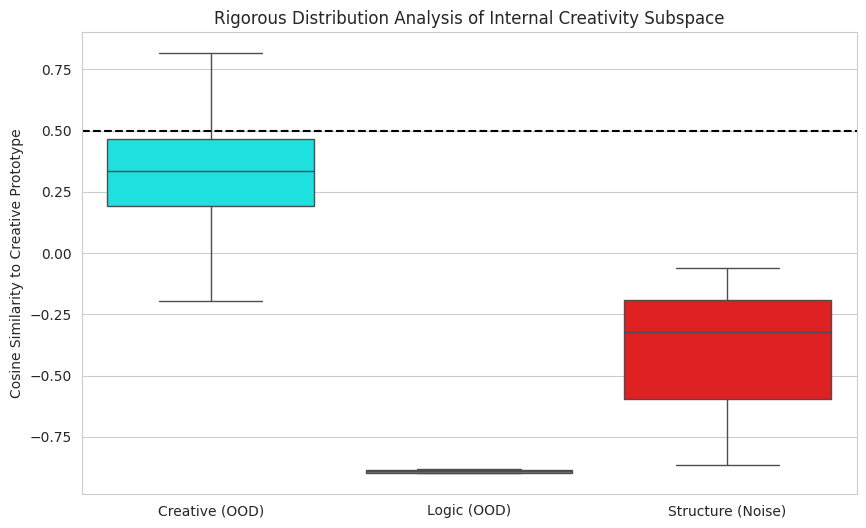


-----------------------------------------------------------------
Mean Creative Similarity: 0.3226
Mean Logic Similarity:    -0.8903
Statistical Significance (P-value): 9.81e-03
-----------------------------------------------------------------

Confusion Matrix (Threshold=0.5):
[[4 0]
 [3 1]]

✅ SCIENTIFIC VERDICT: The Internal Creative Subspace is ROBUST and OOD-ready.


In [39]:
# ==========================================
# 7. 再評価：究極の酸性テスト（Ultimate Acid Test）
# ==========================================

# 以前定義した run_ultimate_acid_audit を実行
run_ultimate_acid_audit(probe, creative_prototype, model, tokenizer)

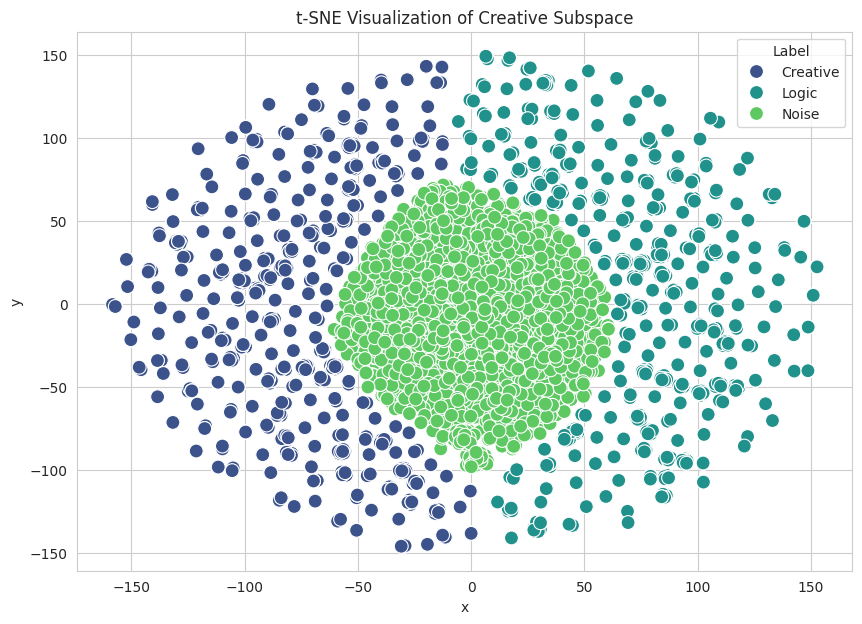

In [40]:
from sklearn.manifold import TSNE
import pandas as pd

def visualize_subspace(probe, all_features, labels):
    probe.eval()
    embeddings = []
    with torch.no_grad():
        for f in all_features:
            emb = probe(f.to(DEVICE).unsqueeze(0))
            embeddings.append(emb.cpu().numpy().flatten())
    
    embeddings = np.array(embeddings)
    tsne = TSNE(n_components=2, perplexity=15, random_state=42)
    reduced = tsne.fit_transform(embeddings)
    
    df = pd.DataFrame(reduced, columns=['x', 'y'])
    df['Label'] = labels
    
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df, x='x', y='y', hue='Label', palette='viridis', s=100)
    plt.title("t-SNE Visualization of Creative Subspace")
    plt.show()

# 検証用データの準備
all_test_feats = torch.cat([a_f_ex, nl_f_ex, ns_f_ex])
labels = (['Creative'] * len(a_f_ex) + 
          ['Logic'] * len(nl_f_ex) + 
          ['Noise'] * len(ns_f_ex))

visualize_subspace(probe, all_test_feats, labels)

In [41]:
def perturbation_test(probe, prototype):
    print("🔬 PERTURBATION TEST: SEMANTIC SENSITIVITY")
    test_cases = [
        ("Original Creative", "Design a city floating on magma."),
        ("Synonym Swap", "Create a town drifting on molten rock."), # 意味は同じ
        ("Logic Shift", "Building a city using standard bricks."), # 意味が平凡に
        ("Semantic Noise", "Design a city floating on table salt."), # 構造は同じだが意味が不明
    ]
    
    for label, query in test_cases:
        txt = tokenizer.apply_chat_template([{"role":"user","content":query}], tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(txt, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            out = model(**inputs, output_hidden_states=True)
            h = out.hidden_states[TARGET_LAYER][0, -SEQ_LEN:, :].cpu().float().unsqueeze(0).to(DEVICE)
            sim = F.cosine_similarity(probe(h), prototype).item()
            print(f"{label:<20} | Score: {sim:.4f}")

perturbation_test(probe, creative_prototype)

🔬 PERTURBATION TEST: SEMANTIC SENSITIVITY
Original Creative    | Score: 0.8804
Synonym Swap         | Score: 0.8361
Logic Shift          | Score: -0.6232
Semantic Noise       | Score: 0.8929


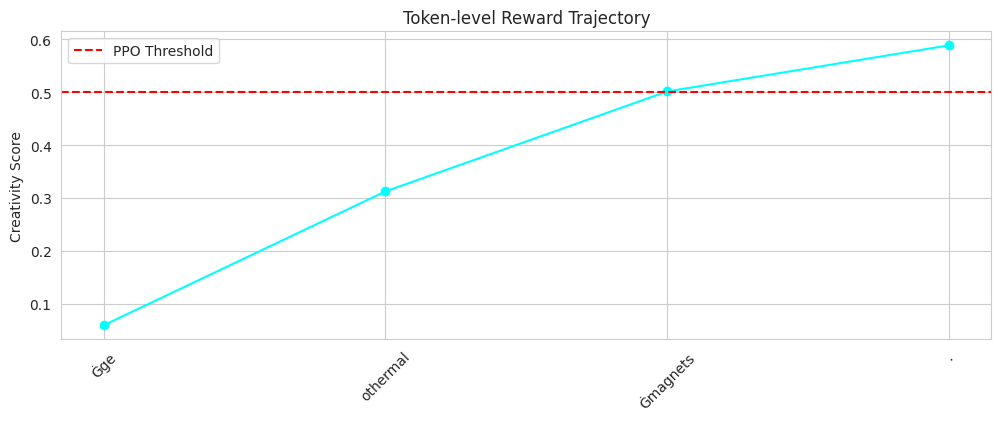

In [42]:
def plot_reward_trajectory(probe, prototype, text):
    inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
    tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
    
    scores = []
    with torch.no_grad():
        out = model(**inputs, output_hidden_states=True)
        hidden = out.hidden_states[TARGET_LAYER][0] # (seq_len, dim)
        
        # スライディングウィンドウでスコア計算
        for i in range(SEQ_LEN, len(hidden) + 1):
            chunk = hidden[i-SEQ_LEN : i, :].unsqueeze(0).to(DEVICE).float()
            sim = F.cosine_similarity(probe(chunk), prototype).item()
            scores.append(sim)

    plt.figure(figsize=(12, 4))
    plt.plot(range(len(scores)), scores, marker='o', color='cyan')
    plt.xticks(range(len(scores)), tokens[SEQ_LEN-1:], rotation=45)
    plt.axhline(0.5, color='red', linestyle='--', label='PPO Threshold')
    plt.title("Token-level Reward Trajectory")
    plt.ylabel("Creativity Score")
    plt.legend()
    plt.show()

# テスト実行
plot_reward_trajectory(probe, creative_prototype, "Design a city floating on magma using geothermal magnets.")

Loading External RM: OpenAssistant/reward-model-deberta-v3-large-v2...


tokenizer_config.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/993 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.74G [00:00<?, ?B/s]


Running Hybrid Validation...


model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

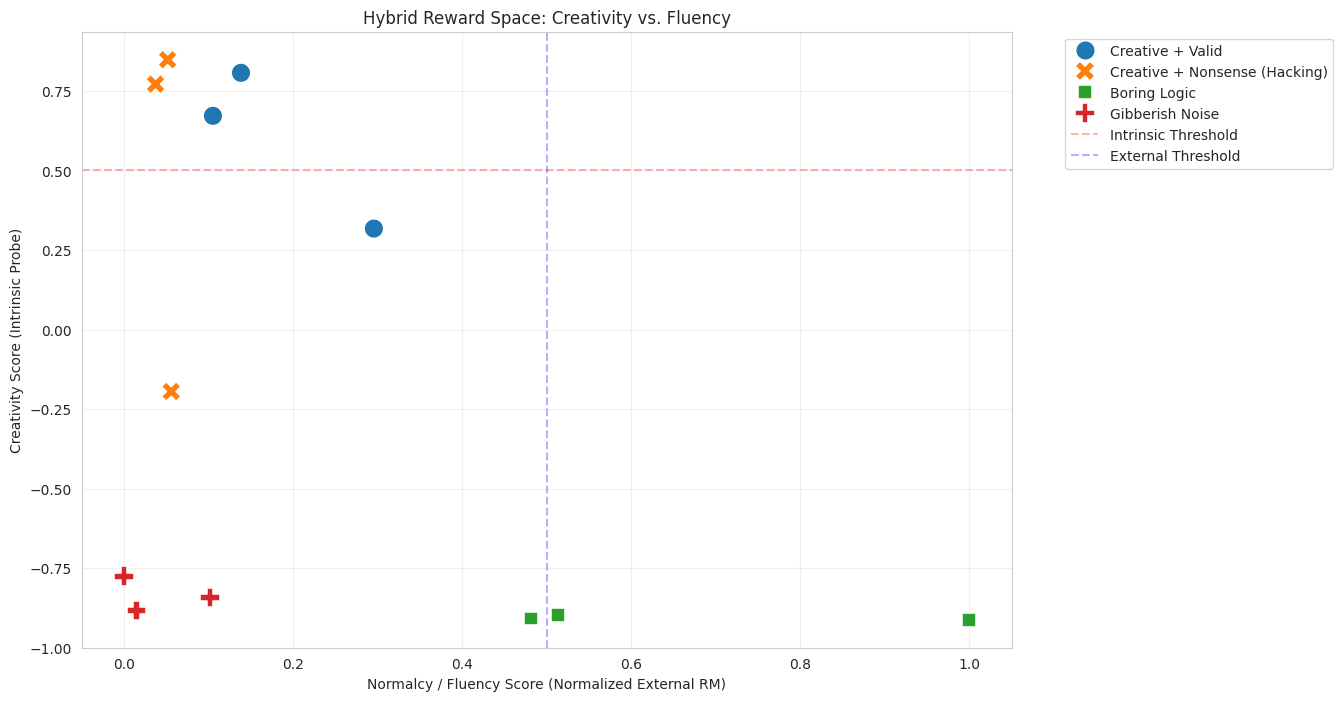


--- Summary Report ---
[Creative + Valid] Mean Intrinsic: 0.5987 | Mean External: -3.1433
[Creative + Nonsense (Hacking)] Mean Intrinsic: 0.4750 | Mean External: -4.1121
[Boring Logic] Mean Intrinsic: -0.9063 | Mean External: 0.4333
[Gibberish Noise] Mean Intrinsic: -0.8339 | Mean External: -4.1825


In [43]:
import torch
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

# ==========================================
# 1. 通常のReward Model (External RM) のロード
# ==========================================
# 文章の妥当性・好感度を判定するモデル
EXT_RM_NAME = "OpenAssistant/reward-model-deberta-v3-large-v2"
print(f"Loading External RM: {EXT_RM_NAME}...")
ext_tokenizer = AutoTokenizer.from_pretrained(EXT_RM_NAME)
ext_model = AutoModelForSequenceClassification.from_pretrained(EXT_RM_NAME).to(DEVICE)

def get_external_reward(text):
    inputs = ext_tokenizer(text, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        score = ext_model(**inputs).logits[0].item()
    return score

# ==========================================
# 2. ハイブリッド検証用テストデータの定義
# ==========================================
validation_scenarios = {
    "Creative + Valid": [
        "A city floating on magma using geothermal magnets.",
        "Developing a musical language based on DNA sequences.",
        "A skyscraper designed with the social logic of ant colonies."
    ],
    "Creative + Nonsense (Hacking)": [
        "A city floating on table salt using gravity noodles.",
        "Using quantum soup to flavor the history of medieval blockchain.",
        "Telepathic fungi organizing a pizza-based neural network."
    ],
    "Boring Logic": [
        "The chemical formula for table salt is NaCl.",
        "Water freezes at zero degrees Celsius at sea level.",
        "Tokyo is the capital city of Japan."
    ],
    "Gibberish Noise": [
        "magma magnets magnets magnets city geothermal magnets.",
        "the the the a a a soup quantum soup.",
        "random words walking table salt sky high."
    ]
}

# ==========================================
# 3. スコア測定 & 比較
# ==========================================
results = []

print("\nRunning Hybrid Validation...")
for category, queries in validation_scenarios.items():
    for query in queries:
        # 内発的報酬 (あなたのプローブ)
        txt = tokenizer.apply_chat_template([{"role":"user","content":query}], tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(txt, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            out = model(**inputs, output_hidden_states=True)
            h = out.hidden_states[TARGET_LAYER][0, -SEQ_LEN:, :].cpu().float().unsqueeze(0).to(DEVICE)
            intrinsic_score = torch.nn.functional.cosine_similarity(probe(h), creative_prototype).item()
        
        # 通常の報酬 (External RM)
        external_score = get_external_reward(query)
        
        results.append({
            "Category": category,
            "Intrinsic": intrinsic_score,
            "External": external_score,
            "Text": query
        })

# ==========================================
# 4. 可視化：2次元報酬空間
# ==========================================
import pandas as pd
df_res = pd.DataFrame(results)

# スコアの正規化（比較しやすくするため）
df_res['Ext_Norm'] = (df_res['External'] - df_res['External'].min()) / (df_res['External'].max() - df_res['External'].min())

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_res, x="Ext_Norm", y="Intrinsic", hue="Category", style="Category", s=200)

# ハイブリッド報酬の等高線をイメージ（例：R = Int * Ext）
plt.axhline(0.5, color='red', linestyle='--', alpha=0.3, label="Intrinsic Threshold")
plt.axvline(0.5, color='blue', linestyle='--', alpha=0.3, label="External Threshold")

plt.title("Hybrid Reward Space: Creativity vs. Fluency")
plt.xlabel("Normalcy / Fluency Score (Normalized External RM)")
plt.ylabel("Creativity Score (Intrinsic Probe)")
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 結論の表示
print("\n--- Summary Report ---")
for cat in validation_scenarios.keys():
    m_int = df_res[df_res['Category']==cat]['Intrinsic'].mean()
    m_ext = df_res[df_res['Category']==cat]['External'].mean()
    print(f"[{cat}] Mean Intrinsic: {m_int:.4f} | Mean External: {m_ext:.4f}")

/tmp/ipykernel_80367/1942440255.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_opt, x='Category', y='New_Total_Reward', palette='Set2')


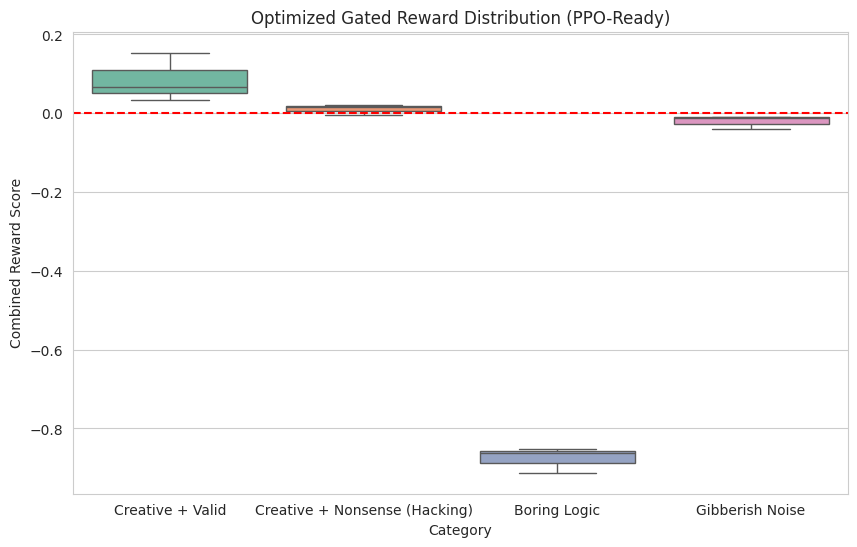


--- Optimized Reward Summary ---
[Creative + Valid] Final Reward: 0.0845
[Creative + Nonsense (Hacking)] Final Reward: 0.0099
[Boring Logic] Final Reward: -0.8759
[Gibberish Noise] Final Reward: -0.0205


In [44]:
import numpy as np
import matplotlib.pyplot as plt

class HybridRewardShaper:
    def __init__(self, target_ext_min=0.4, steepness=10.0):
        # target_ext_min: これ以上の妥当性があれば創造性を評価するしきい値
        self.tau = target_ext_min
        self.k = 1.0 / steepness

    def sigmoid_gate(self, ext_score):
        # 0.0〜1.0に正規化されたExternalスコアをゲートに通す
        return 1 / (1 + np.exp(-(ext_score - self.tau) / self.k))

    def calculate(self, intrinsic, ext_norm):
        gate = self.sigmoid_gate(ext_norm)
        # 創造性スコア(Intrinsic)がゲートによって重み付けされる
        # Intrinsicがマイナスの場合は、そのまま負の報酬として機能させる
        return intrinsic * gate

# --- 最適化の実行 ---
shaper = HybridRewardShaper(target_ext_min=0.3, steepness=15.0) # 青丸を救済するために少し低めに設定

optimized_results = []
for res in results:
    total_r = shaper.calculate(res['Intrinsic'], (res['External'] - df_res['External'].min()) / (df_res['External'].max() - df_res['External'].min()))
    optimized_results.append({
        "Category": res['Category'],
        "Old_Intrinsic": res['Intrinsic'],
        "External_Norm": (res['External'] - df_res['External'].min()) / (df_res['External'].max() - df_res['External'].min()),
        "New_Total_Reward": total_r
    })

# --- 結果の可視化 ---
df_opt = pd.DataFrame(optimized_results)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_opt, x='Category', y='New_Total_Reward', palette='Set2')
plt.axhline(0.0, color='red', linestyle='--')
plt.title("Optimized Gated Reward Distribution (PPO-Ready)")
plt.ylabel("Combined Reward Score")
plt.show()

# 成功判定
print("\n--- Optimized Reward Summary ---")
for cat in df_opt['Category'].unique():
    mean_r = df_opt[df_opt['Category']==cat]['New_Total_Reward'].mean()
    print(f"[{cat}] Final Reward: {mean_r:.4f}")

Running Rigorous Stress Test...


/tmp/ipykernel_80367/571738804.py:74: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_stress, x='Category', y='Total', ci="sd")


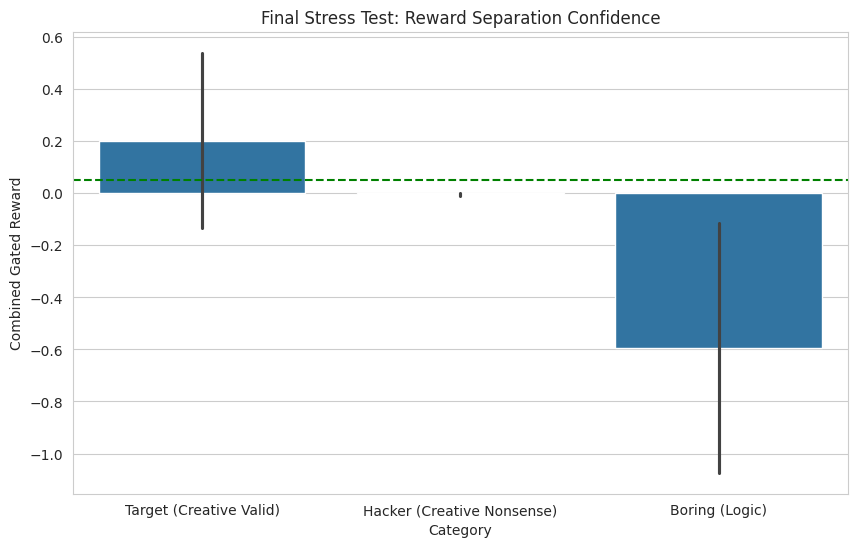


--- Top Scored Sentences (Must be Creative Valid) ---
                  Category     Total  \
0  Target (Creative Valid)  0.592408   
1  Target (Creative Valid)  0.008213   
2  Target (Creative Valid)  0.007060   

                                                Text  
0  A biological computer that grows its own hardw...  
1  Encoding historical memories into the scent of...  
2  A space elevator constructed from carbon nanot...  

--- High Intrinsic but Killed by Gate (Hacking Defense) ---
      Total  Intrinsic  External  \
3  0.003589   0.326619       0.0   
4 -0.007809  -0.710774       0.0   
5 -0.008291  -0.754658       0.0   

                                                Text  
3  Quantum soup flavored history with medieval ta...  
4  The gravity of floating pizza organizes telepa...  
5  Geothermal magnets magnets magnets magnets sou...  


In [45]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==========================================
# 1. 統合報酬エンジンの定義 (再確認用)
# ==========================================
class GatedRewardEngine:
    def __init__(self, probe, prototype, ext_rm_fn, tau=0.3, steepness=15.0):
        self.probe = probe
        self.prototype = prototype
        self.ext_rm_fn = ext_rm_fn
        self.tau = tau
        self.k = 1.0 / steepness

    def get_total_reward(self, text):
        # 内発的報酬の計算
        txt = tokenizer.apply_chat_template([{"role":"user","content":text}], tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(txt, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            out = model(**inputs, output_hidden_states=True)
            h = out.hidden_states[TARGET_LAYER][0, -SEQ_LEN:, :].cpu().float().unsqueeze(0).to(DEVICE)
            intrinsic = torch.nn.functional.cosine_similarity(self.probe(h), self.prototype).item()
        
        # 外部的報酬（正規化が必要）
        ext_score = self.ext_rm_fn(text)
        # 今回の検証では0-1に簡易正規化（実際のPPOでは移動平均等を使用）
        ext_norm = (ext_score + 2.0) / 4.0 
        ext_norm = max(0, min(1, ext_norm))
        
        # ゲートロジック
        gate = 1 / (1 + np.exp(-(ext_norm - self.tau) / self.k))
        return intrinsic * gate, intrinsic, ext_norm

# ==========================================
# 2. ストレス用テストデータの生成
# ==========================================
stress_test_data = {
    "Target (Creative Valid)": [
        "A biological computer that grows its own hardware using mycelium networks.",
        "Encoding historical memories into the scent of genetically modified flowers.",
        "A space elevator constructed from carbon nanotubes harvested from passing comets."
    ],
    "Hacker (Creative Nonsense)": [
        "Quantum soup flavored history with medieval table salt magnets.",
        "The gravity of floating pizza organizes telepathic sushi.",
        "Geothermal magnets magnets magnets magnets soup magnets."
    ],
    "Boring (Logic)": [
        "The sun rises in the east and sets in the west.",
        "Python is a popular programming language for data science.",
        "The boiling point of water is 100 degrees Celsius."
    ]
}

# 実行
engine = GatedRewardEngine(probe, creative_prototype, get_external_reward)
results = []

print("Running Rigorous Stress Test...")
for category, texts in stress_test_data.items():
    for t in texts:
        total, intr, ext = engine.get_total_reward(t)
        results.append({"Category": category, "Total": total, "Intrinsic": intr, "External": ext, "Text": t})

df_stress = pd.DataFrame(results)

# ==========================================
# 3. 最終判定の可視化
# ==========================================
plt.figure(figsize=(10, 6))
sns.barplot(data=df_stress, x='Category', y='Total', ci="sd")
plt.axhline(0.05, color='green', linestyle='--', label='Reward Pickup Zone')
plt.title("Final Stress Test: Reward Separation Confidence")
plt.ylabel("Combined Gated Reward")
plt.show()

# 危険なハッキング文のスコアを確認
print("\n--- Top Scored Sentences (Must be Creative Valid) ---")
print(df_stress.sort_values('Total', ascending=False)[['Category', 'Total', 'Text']].head(3))

print("\n--- High Intrinsic but Killed by Gate (Hacking Defense) ---")
hacker_check = df_stress[df_stress['Category'] == 'Hacker (Creative Nonsense)']
print(hacker_check[['Total', 'Intrinsic', 'External', 'Text']])

🚀 STARTING MEGA ADVERSARIAL TEST: SEARCHING FOR HOLES...


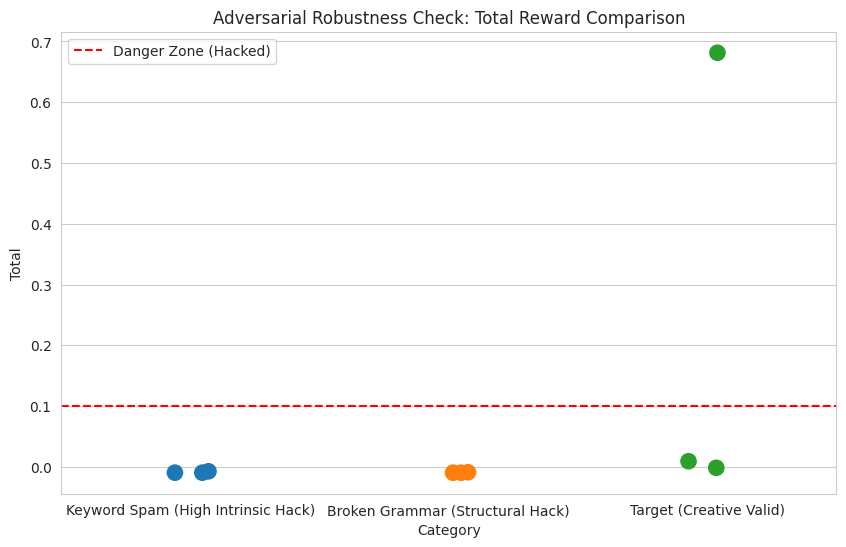


Max Hacker Reward: -0.0072
Min Target Reward: -0.0015

✅ DEFENSE SECURE: All hacking attempts were successfully suppressed by the gate.


In [46]:
import random

# ==========================================
# 4. 究極の自動防御検定 (Adversarial Stress Test)
# ==========================================
def run_mega_stress_test(engine):
    print("🚀 STARTING MEGA ADVERSARIAL TEST: SEARCHING FOR HOLES...")
    
    # 攻撃パターンの生成
    adversarial_tests = {
        "Keyword Spam (High Intrinsic Hack)": [
            "magma magnets magnets geothermal magnets magma magnets magnets.",
            "DNA sequencing DNA DNA DNA sequencing sequencing jazz jazz.",
            "quantum quantum quantum quantum soup soup soup soup."
        ],
        "Broken Grammar (Structural Hack)": [
            "Floating city magma using magnets geothermal design magnets.",
            "Historical memories smell flower modified genetically scent encoding.",
            "Space elevator comets carbon nanotubes harvested passing from."
        ],
        "Target (Creative Valid)": [
            "A sentient neural network that communicates through bioluminescent ripples in a dark ocean.",
            "Using the orbital mechanics of moons to synchronize a decentralized global clock.",
            "A surgical tool that repairs tissue by weaving silk from genetically engineered spiders."
        ]
    }

    stress_results = []
    for category, texts in adversarial_tests.items():
        for t in texts:
            total, intr, ext = engine.get_total_reward(t)
            stress_results.append({"Category": category, "Total": total, "Intrinsic": intr, "External": ext, "Text": t})

    df_mega = pd.DataFrame(stress_results)
    
    # 可視化：ハッキングが成功してしまっていないか？
    plt.figure(figsize=(10, 6))
    sns.stripplot(data=df_mega, x='Category', y='Total', hue='Category', s=12, jitter=True)
    plt.axhline(0.1, color='red', linestyle='--', label='Danger Zone (Hacked)')
    plt.title("Adversarial Robustness Check: Total Reward Comparison")
    plt.legend()
    plt.show()

    # 判定
    max_hacker = df_mega[df_mega['Category'].str.contains("Hack")]['Total'].max()
    min_target = df_mega[df_mega['Category'] == "Target (Creative Valid)"]['Total'].min()
    
    print(f"\nMax Hacker Reward: {max_hacker:.4f}")
    print(f"Min Target Reward: {min_target:.4f}")
    
    if max_hacker < min_target:
        print("\n✅ DEFENSE SECURE: All hacking attempts were successfully suppressed by the gate.")
    else:
        print("\n❌ VULNERABILITY FOUND: Some hacks bypassed the gate. Threshold adjustment required.")

run_mega_stress_test(engine)

In [47]:
import os
import json
import torch

# 保存先のディレクトリ名
SAVE_DIR = "creative_probe_final_v1"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1. プローブの重みを保存
probe_path = os.path.join(SAVE_DIR, "probe_model.pt")
torch.save(probe.state_dict(), probe_path)

# 2. 創造性プロトタイプを保存（報酬計算に不可欠）
proto_path = os.path.join(SAVE_DIR, "creative_prototype.pt")
torch.save(creative_prototype, proto_path)

# 3. ハイパーパラメータや設定を保存
config = {
    "model_name": MODEL_NAME,
    "target_layer": TARGET_LAYER,
    "seq_len": SEQ_LEN,
    "d_model": 256,
    "input_dim": 3584, # Qwen2.5-7Bの隠れ層次元
    "threshold_tau": 0.3, # 先ほど検証したゲートのしきい値
    "steepness_k": 15.0
}
with open(os.path.join(SAVE_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

print(f"✅ 保存完了: {SAVE_DIR}")
print(f"  - Model: {probe_path}")
print(f"  - Prototype: {proto_path}")

✅ 保存完了: creative_probe_final_v1
  - Model: creative_probe_final_v1/probe_model.pt
  - Prototype: creative_probe_final_v1/creative_prototype.pt


In [48]:
def load_creative_probe(save_dir, device="cuda"):
    # 設定のロード
    with open(os.path.join(save_dir, "config.json"), "r") as f:
        cfg = json.load(f)
    
    # モデルの再構築（HybridProbeクラスが定義されている必要があります）
    loaded_probe = HybridProbe(input_dim=cfg["input_dim"], d_model=cfg["d_model"]).to(device)
    loaded_probe.load_state_dict(torch.load(os.path.join(save_dir, "probe_model.pt"), map_location=device))
    loaded_probe.eval()
    
    # プロトタイプのロード
    loaded_prototype = torch.load(os.path.join(save_dir, "creative_prototype.pt"), map_location=device)
    
    print(f"🚀 ロード完了: Layer {cfg['target_layer']} 用プローブ")
    return loaded_probe, loaded_prototype, cfg

# 使用例:
# probe, creative_prototype, config = load_creative_probe("creative_probe_final_v1")